# i200693
## Fahad Maqbool
## AI Project:------

## Here are the steps you can follow to use this dataset for sentiment analysis:

##### 1. Data Preparation: The first step is to download the dataset from the google drive and  preprocess the images and captions. The captions need to be cleaned, converted into lowercase, and tokenized into words. The images should be resized to a standard size and normalized. You can extract visual features from the images using a pre-trained CNN such as ResNet or VGG.

In [65]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from PIL import Image
from torchvision.transforms import transforms
import torch
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')  # Download NLTK punkt tokenizer data
nltk.download('stopwords')  # Download NLTK stopwords data
from torch.nn import Embedding
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import ast
from torchvision import transforms
from sklearn.metrics import classification_report
import string
import itertools
from gensim.models import Word2Vec


[nltk_data] Downloading package punkt to C:\Users\FAHAD
[nltk_data]     MAQBOOL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Mount Google Drive
# drive.mount('/content/drive')

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/sentiment/sentiment.csv')

# Drop the 'Unnamed: 0' column if present
df.drop(columns=['Unnamed: 0'], inplace=True)


# Text processing :-----

In [ ]:
# Convert raw text to lowercase
df['processed_caption'] = df['raw'].apply(lambda x: x.lower())

# Tokenize the raw text
df['tokens_process'] = df['processed_caption'].apply(word_tokenize)

# Remove stop words
stop_words = set(stopwords.words('english'))
df['tokens_process'] = df['tokens_process'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

# Pad tokens to the maximum length
max_length = df['tokens_process'].apply(len).max()
df['tokens_process'] = df['tokens_process'].apply(lambda tokens: tokens + [0] * (max_length - len(tokens)))

# Convert tokens to word vectors using Word2Vec
sentences = df['tokens_process'].tolist()
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Function to extract text features from token sequences using Word2Vec model
def extract_text_features(token_sequences, model):
    text_features = []
    for tokens in token_sequences:
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        if vectors:
            feature = np.mean(vectors, axis=0)  # Compute the mean of word vectors
            text_features.append(feature)
        else:
            text_features.append(np.zeros(model.vector_size))  # Handle tokens with no word vectors
    return np.array(text_features)

# Extract text features from token sequences
text_features = extract_text_features(df['tokens_process'], model)

# Add text features to the DataFrame
df['text_feature'] = list(text_features)

# Image Processing :----

In [ ]:
# Specify the path to the folder containing the images
image_folder = '/content/drive/MyDrive/sentiment/sentiment_images/'

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Function to preprocess an image
def preprocess_image(image_path):
    try:
        # Open the image and convert it to RGB
        image = Image.open(image_path).convert('RGB')
        
        # Define the image transformation pipeline
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Apply the transformation to the image
        image = transform(image)
        
        # Move the image to the GPU device
        image = image.to(device)
        
        return image
    except (FileNotFoundError, Exception) as e:
        # Handle file not found error or image processing error
        print(f"Error processing image at path: {image_path}")
        return None

# Create a new column 'image_path' by concatenating the image folder path and the 'filename' column
df['image_path'] = image_folder + df['filename']

# Apply the 'preprocess_image' function to the 'image_path' column and create a new column 'preprocessed_image'
df['preprocessed_image'] = df['image_path'].apply(preprocess_image)

# Load the pre-trained ResNet-50 model and move it to the GPU device
cnn_model = models.resnet50(pretrained=True)
cnn_model = cnn_model.eval()
cnn_model = cnn_model.to(device)

# Function to extract visual features from an image
def extract_visual_features(image):
    if image is None:
        return None
    image = image.unsqueeze(0)
    image = image.to(device)
    with torch.no_grad():
        features = cnn_model(image)
    return features.squeeze()

# Apply the 'extract_visual_features' function to the 'preprocessed_image' column and create a new column 'visual_features'
df['visual_features'] = df['preprocessed_image'].apply(extract_visual_features)

# Process data:--

In [80]:
# Read the CSV file into a DataFrame
df = pd.read_csv('process_data.csv')

# Drop the 'Unnamed: 0' column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Convert the 'text_feature' column from string representation to numpy array of float32
df['text_feature'] = df['text_feature'].apply(lambda x: np.array(x.strip('[]').split(), dtype=np.float32))

# Process the 'visual_features' column
df['visual_features'] = df['visual_features'].apply(lambda x: np.array(str(x).split('[')[-1].split(']')[0].split(','), dtype=float))

# Convert the 'visual_features' column to torch tensor
df['visual_features'] = df['visual_features'].apply(lambda x: torch.tensor(x))

# Drop rows with missing values
df.dropna(inplace=True)

# Check for missing values in the DataFrame
df.isna().sum()


imgid                 0
split                 0
filename              0
successful            0
tokens                0
word_sentiment        0
sentiment             0
raw                   0
processed_caption     0
tokens_process        0
text_feature          0
image_path            0
preprocessed_image    0
visual_features       0
dtype: int64

In [83]:
# Split the tokens column into a list of token sequences
split_tokens = [x[1:-1].split(", ") for x in df["tokens"].tolist()]

# Remove the square brackets from individual tokens
split_tokens = [[y[1:-1] for y in x] for x in split_tokens]

# Create a new column 'tokens_words' to store the token sequences
df['tokens_words'] = split_tokens

# Find the maximum length of token sequences
max_len = len(df['tokens_words'].max())

# Pad the token sequences with zeros to match the maximum length
df['tokens_words'] = df['tokens_words'].apply(lambda tokens: tokens + [0] * (max_len - len(tokens)))

# Convert the 'word_sentiment' column from string representation to list
df['word_sentiment'] = df['word_sentiment'].apply(lambda x: ast.literal_eval(x))

# Pad the sentiment scores with zeros to match the maximum length
df['word_sentiment'] = df['word_sentiment'].apply(lambda tokens: tokens + [0] * (max_len - len(tokens)))

# Display the first token sequence after padding
display(df['tokens_words'][0])

# Display the first sentiment scores after padding
display(df['word_sentiment'][0])

# Convert the token sequences to word features using Word2Vec model
sentences = df['tokens_words'].tolist()
model = Word2Vec(sentences, vector_size=25, window=5, min_count=1, workers=4)

def extract_text_features(token_sequences, model):
    text_features = []
    for tokens in token_sequences:
        vectors = [model.wv[word] for word in tokens if word in model.wv]
        if vectors:
            feature = np.mean(vectors, axis=0)  # Compute the mean of word vectors
            text_features.append(feature)
        else:
            text_features.append(np.zeros(model.vector_size))  # Handle tokens with no word vectors
    return np.array(text_features)

# Extract word features for each token sequence
word_features = extract_text_features(df['tokens_words'], model)

# Assign the word features to the 'word_features' column
df['word_features'] = list(word_features)


In [84]:
df

,imgid,split,filename,successful,tokens,word_sentiment,sentiment,raw,processed_caption,tokens_process,text_feature,image_path,preprocessed_image,visual_features,tokens_words,word_features
0,31369,train,COCO_val2014_000000389081.jpg,1,"['a', 'plate', 'of', 'delicious', 'food', 'inc...","[0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0, 0, 0, 0, ...",1,a plate of delicious food including French fries.,a plate of delicious food including french fries.,"['plate', 'delicious', 'food', 'including', 'f...","[0.14435287, -0.39209256, 0.60560834, -0.35789...",/content/drive/MyDrive/sentiment/sentiment_ima...,"tensor([[[-1.5699, -1.5357, -1.5185, ..., -1....","[tensor(2.9000, dtype=torch.float64), tensor(-...","[a, plate, of, delicious, food, including, fre...","[1.1180228, -0.37944388, -0.084031604, -0.7050..."
1,31369,train,COCO_val2014_000000389081.jpg,1,"['french', 'fries', 'are', 'not', 'a', 'health...","[0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0,...",1,French fries are not a healthy food but it is ...,french fries are not a healthy food but it is ...,"['french', 'fries', 'healthy', 'food', 'excell...","[0.12529851, -0.392354, 0.5898358, -0.3611061,...",/content/drive/MyDrive/sentiment/sentiment_ima...,"tensor([[[-1.5699, -1.5357, -1.5185, ..., -1....","[tensor(2.9000, dtype=torch.float64), tensor(-...","[french, fries, are, not, a, healthy, food, bu...","[1.0003605, -0.35224086, 0.08382912, -0.792501..."
2,31369,train,COCO_val2014_000000389081.jpg,1,"['the', 'plate', 'has', 'one', 'of', 'my', 'fa...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 0.0, 0.0,...",1,"The plate has one of my favorite foods on it, ...","the plate has one of my favorite foods on it, ...","['plate', 'one', 'favorite', 'foods', ',', 'fr...","[0.11975639, -0.33411312, 0.6227862, -0.328492...",/content/drive/MyDrive/sentiment/sentiment_ima...,"tensor([[[-1.5699, -1.5357, -1.5185, ..., -1....","[tensor(2.9000, dtype=torch.float64), tensor(-...","[the, plate, has, one, of, my, favorite, foods...","[0.96932065, -0.35699126, -0.0015931309, -0.71..."
3,31369,train,COCO_val2014_000000389081.jpg,1,"['it', 'was', 'disgusting', 'food', 'not', 'ju...","[0.0, 0.0, 1, 1, 0.0, 0.0, 1, 1, 0, 0, 0, 0, 0...",0,"It was disgusting food, not just bad food.","it was disgusting food, not just bad food.","['disgusting', 'food', ',', 'bad', 'food', '.'...","[0.13780436, -0.407391, 0.60546184, -0.3719354...",/content/drive/MyDrive/sentiment/sentiment_ima...,"tensor([[[-1.5699, -1.5357, -1.5185, ..., -1....","[tensor(2.9000, dtype=torch.float64), tensor(-...","[it, was, disgusting, food, not, just, bad, fo...","[1.2341136, -0.51621985, -0.05004932, -0.67997..."
4,31369,train,COCO_val2014_000000389081.jpg,1,"['a', 'plate', 'of', 'disgusting', 'food', 'fo...","[0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0, 0.0, 0, 0...",0,A plate of disgusting food found at a diner.,a plate of disgusting food found at a diner.,"['plate', 'disgusting', 'food', 'found', 'dine...","[0.13693358, -0.41861236, 0.6273109, -0.348105...",/content/drive/MyDrive/sentiment/sentiment_ima...,"tensor([[[-1.5699, -1.5357, -1.5185, ..., -1....","[tensor(2.9000, dtype=torch.float64), tensor(-...","[a, plate, of, disgusting, food, found, at, a,...","[1.096952, -0.32524014, -0.039901063, -0.80140..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39176,23481,test,COCO_val2014_000000467249.jpg,1,"['i', 'think', 'there', 'is', 'a', 'broken', '...","[0.0, 0.0, 0.0, 0.0, 0.0, 1, 1, 0.0, 0.0, 0.0,...",0,I think there is a broken window on the clock ...,i think there is a broken window on the clock ...,"['think', 'broken', 'window', 'clock', 'tower'...","[-0.01054071, -0.3633859, 0.83063734, -0.34671...",/content/drive/MyDrive/sentiment/sentiment_ima...,"tensor([[[ 0.3138, 0.3138, 0.3309, ..., 0....","[tensor(-3.9285, dtype=torch.float64), tensor(...","[i, think, there, is, a, broken, window, on, t...","[1.0628843, -0.26338357, 0.07811466, -0.878417..."
39177,23481,test,COCO_val2014_000000467249.jpg,1,"['a', 'large', 'abandoned', 'bui

# Task 01: PyTorch Model for Sentence level Multimodal Sentiment Analysis

In [127]:
import torch
import torch.nn as nn

class MultimodalNetwork(nn.Module):
    def __init__(self, text_input_size, image_input_size, hidden_sizes, output_size):
        super(MultimodalNetwork, self).__init__()

        # Textual network
        self.text_net = nn.Sequential(
            nn.Linear(text_input_size, hidden_sizes[0]),  # Input size to the first hidden layer
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], hidden_sizes[7]),  # Output size of the textual network
            nn.ReLU()
        )

        # Visual network
        self.image_net = nn.Sequential(
            nn.Linear(image_input_size, hidden_sizes[4]),  # Input size to the first hidden layer
            nn.ReLU(),
            nn.Linear(hidden_sizes[4], hidden_sizes[5]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[5], hidden_sizes[6]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[6], hidden_sizes[7]),  # Output size of the visual network
            nn.ReLU()
        )

        # Combined network
        self.combined_net = nn.Sequential(
            nn.Linear(hidden_sizes[7] + hidden_sizes[7], hidden_sizes[8]),  # Input size: concatenation of textual and visual output
            nn.ReLU(),
            nn.Linear(hidden_sizes[8], hidden_sizes[9]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[9], hidden_sizes[10]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[10], hidden_sizes[11]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[11], output_size)  # Output size of the combined network
        )

    def forward(self, text_features, image_features):
        text_output = self.text_net(text_features.float())  # Convert to float data type
        image_output = self.image_net(image_features.float())  # Convert to float data type
        combined = torch.cat((text_output, image_output), dim=1)  # Concatenate the textual and visual outputs
        output = self.combined_net(combined)  # Pass the concatenated output through the combined network
        return output


In [126]:
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

class YourDataset(Dataset):
    def __init__(self, text_features, image_features, labels):
        """
        Initialize the dataset with text features, image features, and labels.

        Args:
            text_features (list): List of text features.
            image_features (list): List of image features.
            labels (list): List of corresponding labels.
        """
        self.text_features = text_features
        self.image_features = image_features
        self.labels = labels

    def __len__(self):
        """
        Return the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.text_features)

    def __getitem__(self, index):
        """
        Get an item from the dataset at the specified index.

        Args:
            index (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing text tensor, image tensor, and label tensor.
        """
        text = self.text_features[index]
        image = self.image_features[index]
        label = self.labels[index]

        # Convert to tensors
        text_tensor = torch.Tensor(text)

        if image is not None:
            image_tensor = torch.Tensor(image)
        else:
            # Handle the case when image is None
            image_tensor = torch.zeros_like(text_tensor)

        label_tensor = torch.Tensor([label])

        return text_tensor, image_tensor, label_tensor
    
    def collate_fn(self, batch):
        """
        Collate function for batching the dataset.

        Args:
            batch (list): List of samples to batch.

        Returns:
            tuple: A tuple containing padded text, padded images, and padded labels.
        """
        text_batch, image_batch, label_batch = zip(*batch)
        text_padded = pad_sequence(text_batch, batch_first=True)

        if image_batch[0].shape[0] > 0:
            image_padded = pad_sequence(image_batch, batch_first=True)
        else:
            # Handle the case when all image tensors are empty
            image_padded = torch.zeros_like(text_padded)

        label_padded = torch.cat(label_batch).unsqueeze(1)  # Unsqueeze the label tensor

        return text_padded, image_padded, label_padded


In [104]:

# Define the input sizes and other hyperparameters
text_input_size = len(df['text_feature'].iloc[0])
image_input_size = df['visual_features'].iloc[0].shape[0] # Assuming each 'visual_features' entry is a 1D array
hidden_sizes = [512*2, 256*2, 512*2, 256*2, 128*2, 64*2, 128*2, 64*2, 32*2, 16*2, 8*2,4*2]
output_size = 1 # Assuming a binary classification task

# Define the hyperparameters for training
learning_rate = 0.001
batch_size = 32
num_epochs = 15

# Split the data into training and validation sets
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

# Assuming you have train_data, val_data as your training and validation sets
train_text_features = train_data['text_feature'].values
train_image_features = train_data['visual_features'].values
train_labels = train_data['sentiment'].values

# Assuming you have defined batch_size and other hyperparameters
train_dataset = YourDataset(train_text_features, train_image_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)

# Assuming you have train_data, val_data as your training and validation sets
val_text_features = val_data['text_feature'].values
val_image_features = val_data['visual_features'].values
val_labels = val_data['sentiment'].values

# Assuming you have defined batch_size and other hyperparameters
val_dataset = YourDataset(val_text_features, val_image_features, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)



# Check if GPU is available and choose device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the MultimodalNetwork model
model = MultimodalNetwork(text_input_size, image_input_size, hidden_sizes, output_size)
model = model.to(device)  # Move the model to the same device as the input tensors

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# TRAINING SENTENCE SENTIMENT MODEL:------------

In [105]:
from sklearn.metrics import classification_report

train_losses = []
train_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for text_features, image_features, labels in train_loader:
        text_features = text_features.to(device)
        image_features = image_features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(text_features, image_features)

        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate the training loss and correct predictions
        train_loss += loss.item()
        train_correct += torch.sum(torch.round(torch.sigmoid(outputs)).long() == labels.squeeze(0).long()).item()

    # Compute average training loss and accuracy
    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_data)
    
    # Append training loss and accuracy to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")


Epoch 1/15
Train Loss: 0.6859, Train Accuracy: 0.5441
Epoch 2/15
Train Loss: 0.6800, Train Accuracy: 0.5401
Epoch 3/15
Train Loss: 0.6653, Train Accuracy: 0.5490
Epoch 4/15
Train Loss: 0.6452, Train Accuracy: 0.5653
Epoch 5/15
Train Loss: 0.5909, Train Accuracy: 0.6451
Epoch 6/15
Train Loss: 0.4665, Train Accuracy: 0.7661
Epoch 7/15
Train Loss: 0.3982, Train Accuracy: 0.8037
Epoch 8/15
Train Loss: 0.3497, Train Accuracy: 0.8390
Epoch 9/15
Train Loss: 0.3301, Train Accuracy: 0.8436
Epoch 10/15
Train Loss: 0.3071, Train Accuracy: 0.8565
Epoch 11/15
Train Loss: 0.2917, Train Accuracy: 0.8617
Epoch 12/15
Train Loss: 0.2749, Train Accuracy: 0.8716
Epoch 13/15
Train Loss: 0.2568, Train Accuracy: 0.8765
Epoch 14/15
Train Loss: 0.2260, Train Accuracy: 0.8885
Epoch 15/15
Train Loss: 0.2227, Train Accuracy: 0.8891


# TESTING  SENTENCE SENTIMENT MODEL:------------

In [106]:
# Evaluation loop
model.eval()
val_loss = 0.0
val_correct = 0
val_true_labels = []
val_pred_labels = []
val_losses = []
val_accuracies = []

with torch.no_grad():
    for text_features, image_features, labels in val_loader:
        text_features = text_features.to(device)
        image_features = image_features.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(text_features, image_features)

        loss = criterion(outputs, labels)

        # Accumulate the validation loss and correct predictions
        val_loss += loss.item()
        val_correct += torch.sum(torch.round(torch.sigmoid(outputs)).long() == labels.squeeze(0).long()).item()

        # Append true labels and predicted labels for evaluation
        val_true_labels.extend(labels.squeeze(0).long().tolist())
        val_pred_labels.extend(torch.round(torch.sigmoid(outputs)).long().tolist())

    # Compute average validation loss and accuracy
    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_data)
    
    # Append validation loss and accuracy to lists
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print validation results
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Compute classification report
report = classification_report(val_true_labels, val_pred_labels)
print("Classification Report:")
print(report)


Validation Loss: 0.0026, Validation Accuracy: 0.0158
Validation Loss: 0.0063, Validation Accuracy: 0.0296
Validation Loss: 0.0033, Validation Accuracy: 0.0449
Validation Loss: 0.0025, Validation Accuracy: 0.0607
Validation Loss: 0.0029, Validation Accuracy: 0.0760
Validation Loss: 0.0048, Validation Accuracy: 0.0918
Validation Loss: 0.0032, Validation Accuracy: 0.1071
Validation Loss: 0.0069, Validation Accuracy: 0.1208
Validation Loss: 0.0029, Validation Accuracy: 0.1356
Validation Loss: 0.0036, Validation Accuracy: 0.1509
Validation Loss: 0.0033, Validation Accuracy: 0.1662
Validation Loss: 0.0038, Validation Accuracy: 0.1815
Validation Loss: 0.0041, Validation Accuracy: 0.1963
Validation Loss: 0.0044, Validation Accuracy: 0.2106
Validation Loss: 0.0015, Validation Accuracy: 0.2274
Validation Loss: 0.0150, Validation Accuracy: 0.2412
Validation Loss: 0.0038, Validation Accuracy: 0.2559
Validation Loss: 0.0038, Validation Accuracy: 0.2712
Validation Loss: 0.0026, Validation Accuracy: 

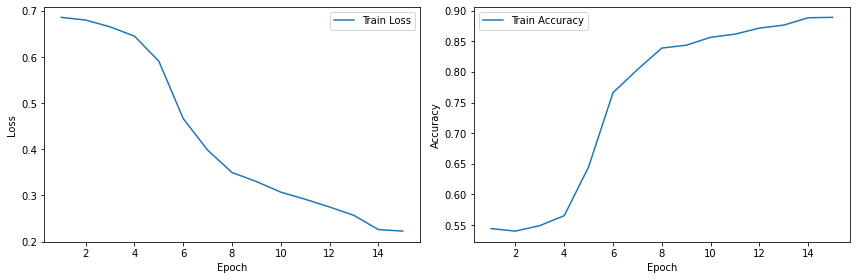

In [107]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [42]:
# Save the trained model
torch.save(model.state_dict(), 'model_sentence.pth')


# Task 02: PyTorch Model for Word level Sentiment Analysis
#### Do word level sentiment analysis by making custom feature vector.

In [117]:
class MultimodalNetwork(nn.Module):
    def __init__(self, input_text_size, input_image_size, hidden_sizes, output_size):
        super(MultimodalNetwork, self).__init__()

        # Textual network
        self.text_net = nn.Sequential(
            nn.Linear(input_text_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], hidden_sizes[3]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[3], hidden_sizes[4]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[4], hidden_sizes[5]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[5], hidden_sizes[6]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[6], hidden_sizes[7]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[7], hidden_sizes[8]),
            nn.ReLU()
        )

        # Visual network
        self.image_net = nn.Sequential(
            nn.Linear(input_image_size, hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], hidden_sizes[3]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[3], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], hidden_sizes[3]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[3], hidden_sizes[3]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[3], hidden_sizes[3]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[3], hidden_sizes[3]),
            nn.ReLU()
        )

        # Combined network
        self.combined_net = nn.Sequential(
            nn.Linear(hidden_sizes[3] + hidden_sizes[8], hidden_sizes[9]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[9], hidden_sizes[10]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[10], hidden_sizes[11]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[11], hidden_sizes[12]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[12], hidden_sizes[12]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[12], hidden_sizes[12]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[12], hidden_sizes[12]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[12], hidden_sizes[12]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[12], hidden_sizes[12]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[12], output_size)
        )


    def forward(self, text_features, image_features):
        """
        Forward pass of the multimodal network.

        Args:
            text_features (torch.Tensor): Input textual features.
            image_features (torch.Tensor): Input image features.

        Returns:
            torch.Tensor: Output predictions.
        """
        text_output = self.text_net(text_features.float())
        image_output = self.image_net(image_features.float())
        combined = torch.cat((text_output, image_output), dim=1)
        output = self.combined_net(combined)
        return output



In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset

class YourDataset(Dataset):
    def __init__(self, text_features, image_features, labels):
        """
        Initialize the dataset with text features, image features, and labels.

        Args:
            text_features (list): List of text features.
            image_features (list): List of image features.
            labels (list): List of corresponding labels.
        """
        self.text_features = text_features
        self.image_features = image_features
        self.labels = labels

    def __len__(self):
        """
        Return the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.text_features)

    def __getitem__(self, index):
        """
        Get an item from the dataset at the specified index.

        Args:
            index (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing text tensor, image tensor, and label tensor.
        """
        text = self.text_features[index]
        image = self.image_features[index]
        label = self.labels[index]

        text_tensor = torch.Tensor(text)

        if image is not None:
            image_tensor = torch.Tensor(image)
        else:
            image_tensor = torch.zeros_like(text_tensor)

        label_tensor = torch.Tensor(label)

        return text_tensor, image_tensor, label_tensor
    
    def collate_fn(self, batch):
        """
        Collate function for batching the dataset.

        Args:
            batch (list): List of samples to batch.

        Returns:
            tuple: A tuple containing padded text, padded images, and padded labels.
        """
        text_batch, image_batch, label_batch = zip(*batch)
        text_padded = pad_sequence(text_batch, batch_first=True)

        if image_batch[0].shape[0] > 0:
            image_padded = pad_sequence(image_batch, batch_first=True)
        else:
            image_padded = torch.zeros_like(text_padded)

        labels = []
        for label in label_batch:
            if label.shape[0] > text_padded.shape[1]:
                label = label[:text_padded.shape[1]]
            labels.append(label)

        label_padded = pad_sequence(labels, batch_first=True)

        return text_padded, image_padded, label_padded


In [120]:
# Define input sizes, hidden sizes, output size, and other hyperparameters
input_text_size = len(df['word_features'].iloc[0])
input_image_size = df['visual_features'].iloc[0].shape[0]
hidden_sizes = [512*2, 256*2, 128*2, 256*2, 128*2, 64*2, 32*2, 64*2, 32*2, 16*2, 8*2, 4*2, 25*2]
output_size = 25

lr = 0.001
batch_size = 32
num_epochs = 10


# Split the dataset into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Get the training features, labels, and create the training dataset and data loader
train_features1 = train['word_features'].values
train_features2 = train['visual_features'].values
train_labels = train['word_sentiment'].values
train_dataset = YourDataset(train_features1, train_features2, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)

# Get the testing features, labels, and create the testing dataset and data loader
test_features1 = test['word_features'].values
test_features2 = test['visual_features'].values
test_labels = test['word_sentiment'].values
test_dataset = YourDataset(test_features1, test_features2, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_dataset.collate_fn)

# Set the device to CUDA if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to the appropriate device
model = MultimodalNetwork(input_text_size, input_image_size, hidden_sizes, output_size)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


#  TRAINING WORDS SENTIMENT MODEL :----

Epoch 1/10
Train Loss: 0.2883, Train Accuracy: 0.8934
Epoch 2/10
Train Loss: 0.2445, Train Accuracy: 0.9041
Epoch 3/10
Train Loss: 0.2369, Train Accuracy: 0.9049
Epoch 4/10
Train Loss: 0.2318, Train Accuracy: 0.9055
Epoch 5/10
Train Loss: 0.2279, Train Accuracy: 0.9078
Epoch 6/10
Train Loss: 0.2261, Train Accuracy: 0.9089
Epoch 7/10
Train Loss: 0.2217, Train Accuracy: 0.9107
Epoch 8/10
Train Loss: 0.2179, Train Accuracy: 0.9119
Epoch 9/10
Train Loss: 0.2178, Train Accuracy: 0.9124
Epoch 10/10
Train Loss: 0.2134, Train Accuracy: 0.9135


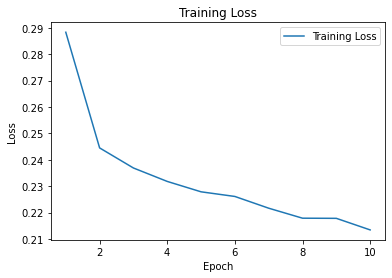

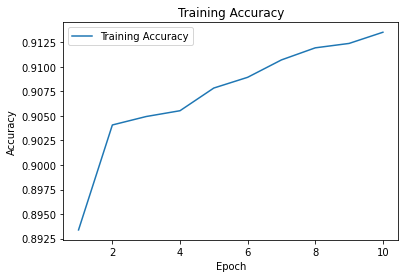

In [121]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0
    for text_features, image_features, labels in train_loader:
        # Move data to the appropriate device (CPU or GPU)
        text_features = text_features.to(device)
        image_features = image_features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(text_features, image_features)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the training loss and accuracy
        train_loss += loss.item()
        train_acc += torch.sum(torch.round(torch.sigmoid(outputs)).long() == labels.long()).item()

    # Compute average training loss and accuracy for the epoch
    train_loss /= len(train_loader)
    train_accuracy = train_acc / (len(train) * output_size)
    
    # Store the loss and accuracy values
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Print epoch information
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

# Plot the training loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot the training accuracy
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()


#  TESTING WORDS SENTIMENT MODEL :----

In [79]:
# Initialize evaluation variables
model.eval()
test_loss = 0.0
test_acc = 0
test_true_labels = []
test_pred_labels = []

# Disable gradient calculation during evaluation
with torch.no_grad():
    for text_features, image_features, labels in test_loader:
        text_features = text_features.to(device)
        image_features = image_features.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(text_features, image_features)
        loss = criterion(outputs, labels)

        # Accumulate the test loss and accuracy
        test_loss += loss.item()
        test_acc += torch.sum(torch.round(torch.sigmoid(outputs)).long() == labels.long()).item()

        # Append true labels and predicted labels for evaluation
        test_true_labels.extend(labels.squeeze(0).long().tolist())
        test_pred_labels.extend(torch.round(torch.sigmoid(outputs)).long().tolist())

    # Compute average test loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = test_acc / (len(test) * output_size)

    # Print test results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Compute classification report
report = classification_report(test_true_labels, test_pred_labels)
print("Classification Report:")
print(report)


Test Loss: 0.2129, Test Accuracy: 0.9159
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.66      0.66      0.66       774
           2       0.64      0.65      0.64       782
           3       0.00      0.00      0.00       234
           4       0.00      0.00      0.00       227
           5       0.00      0.00      0.00       239
           6       0.00      0.00      0.00       265
           7       0.56      0.09      0.16       299
           8       0.52      0.27      0.35       335
           9       0.00      0.00      0.00       353
          10       0.00      0.00      0.00       274
          11       0.00      0.00      0.00       163
          12       0.00      0.00      0.00       124
          13       0.00      0.00      0.00        96
          14       0.00      0.00      0.00        78
          15       0.00      0.00      0.00        45
          16     

C:\Users\FAHAD MAQBOOL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\FAHAD MAQBOOL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\FAHAD MAQBOOL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Task 03: PyTorch Model for Positive Sentiment Caption Generation

##### The task at hand is to create a PyTorch model that can generate positive sentiment captions by training it on a large dataset of positive captions. This can be achieved by fine-tuning a pre-existing model or creating a new one from scratch. The ultimate goal is to develop a model that can generate high-quality, positive captions that accurately reflect the content of the input image.

In [1]:
import torch
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, GPT2Tokenizer, GPT2LMHeadModel
from PIL import Image
import pandas as pd

# Load the GPT-2 tokenizer and language model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
lm_model = GPT2LMHeadModel.from_pretrained("gpt2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lm_model.to(device)

def fine_tune_positive_model(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Get the captions and labels
    captions = df["raw"].tolist()
    labels = df["sentiment"].tolist()

    # Filter out captions with label 1 (positive)
    positive_captions = [caption for caption, label in zip(captions, labels) if label == 1]

    # Tokenize the positive caption dataset
    tokenized_dataset = tokenizer.batch_encode_plus(
        positive_captions,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )

    # Save the fine-tuned model
    lm_model.save_pretrained("enhanced_model")

def enhance_positive_caption(caption):
    # Load the enhanced model
    enhanced_model = GPT2LMHeadModel.from_pretrained("enhanced_model")
    enhanced_model.to(device)

    # Encode the input caption
    encoded_caption = tokenizer.encode(caption, return_tensors="pt").to(device)
    attention_mask = torch.ones_like(encoded_caption).to(device)

    # Generate multiple enhanced captions
    generated_output = enhanced_model.generate(
        encoded_caption,
        attention_mask=attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        max_length=30,
        num_beams=8,
        no_repeat_ngram_size=2,
        num_return_sequences=2
    )

    enhanced_positive_captions = []
    for output in generated_output:
        generated_caption = tokenizer.decode(output, skip_special_tokens=True)
        enhanced_positive_captions.append(generated_caption)
    return enhanced_positive_captions

# Load the Vision Encoder-Decoder model, image processor, and GPT-2 language model
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
lm_model = GPT2LMHeadModel.from_pretrained("gpt2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
lm_model.to(device)

max_length = 30
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

def predict_step(image_paths):
    images = []
    for image_path in image_paths:
        # Open the image and convert it to RGB if necessary
        i_image = Image.open(image_path)
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")

        images.append(i_image)

    # Process the images using the ViT image processor
    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    # Generate captions using the Vision Encoder-Decoder model
    output_ids = model.generate(pixel_values, **gen_kwargs)

    # Filter out negative captions
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    positive_preds = [pred.strip() for pred in preds if "negative" not in pred]

    # Select the best positive caption
    best_positive_caption = max(positive_preds, key=len)

    # Generate enhanced positive captions
    enhanced_captions = enhance_positive_caption(best_positive_caption)

    return enhanced_captions

# Fine-tune the GPT-2 model using positive captions from a CSV file
fine_tune_positive_model('caption.csv')

# Example usage
image_paths = ["./sentiment/sentiment_images/COCO_val2014_000000032284.jpg"]
enhanced_captions = predict_step(image_paths)

for i, image_path in enumerate(image_paths):
    print("Image:", image_path)
    print("Caption:", enhanced_captions[i])




Image: cap.jpg
Caption: a young boy holding a red and white fire hydrant in his hand.

"I don't know what to do," he said. "
